# Emcee GP Study

An emcee sampler notebook, testing various things about the emcee package.

In [56]:
%matplotlib notebook 
#restart the kernel if switching from inline to notebook
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import corner

import numpy as np
import scipy.stats
import pandas as pd

import emcee
import george

import pickle
import gp_sandbox as cgp


def sample(days=1, delay=0, plot=True):
    
    """
    Samples the number of points from the provided lightcurve at a 
    specified cadence.
    The total simulated light curve has around 400,000 points/~160 days.
    
    Parameters
    ----------
    days : int
        The number of nights you wish to sample. There are 2880 data 
        points in each day.
        
    delay : int
        The number of days you wish to delay by. This allows the user to
        sample the lightcurve somewhere other than just the start.
        Note : you cannot delay by more than 158 days or the data runs 
        out.
        
    plot : boolean
        Decides whether you want to plot the original light curve and 
        the sampled data points.
    
    Returns
    -------
    time : pandas.core.series.Series
        The time stamp information of the sampled lightcurve in days.
        
    flux : pandas.core.series.Series
        Flux measurements of sampled lightcurve corresponding to the
        time stamps.
        
    flux_err : numpy.ndarray
        Estimated flux error corresponding to the flux measurements.
        
    ax : matplotlib.axes._subplots.AxesSubplot

    """
    # halt if you delay past he limit of the data
    assert delay < 159 , "You cannot delay more than 158 days."
    
    # convert days to points
    span = 2880 * days
    start_pt = 2880 * delay
    
    # read in lightcurve data 
    df = pd.read_csv('new_shape_models/1388_lc_49627_to_49787_realistic.txt', delimiter=' ',
                     header=None, names=['all_time','all_flux'], dtype={'all_time':float, 'all_flux':float})
    all_time = df.all_time
    all_flux = df.all_flux
    
    # halt if you sample past the limit of the data
    assert 2880*(delay+days) < len(df.all_time) , "End of data reached. You cannot delay that many days."
    
    time = all_time[start_pt:span+start_pt]
    flux = all_flux[start_pt:span+start_pt]

    # yerr is set to 0.2 magnitude but can easily be changed
    # cadance sampling is turned on
    # can be switched to random or clustered
    tsample, fsample, flux_err = cgp.sample_data(time, flux, yerr_amp=0.2, cadence_n=1) 

    if plot == True:
        ax = plot_sample(time, flux, tsample, fsample)
        return tsample, fsample, time, flux, flux_err, ax

    else: return tsample, fsample, time, flux, flux_err


def plot_sample(time, flux, tsample, fsample):
    
    """
    Plot the sampled data points.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.plot(time, flux, '-', alpha=0.5, label="Original")
    ax.plot(tsample, fsample, 'ko', ms = 3, alpha=0.5, 
                 label="Sample : " + str(len(tsample)))
    ax.legend()
    return ax
    

    
def prior(params):
    
    """
    Calculated the log of the prior values, given parameter values.
    
    Parameters
    ----------
    params : list
        List of all kernel parameters
    
    param[0] : float
        mean (between 0 and 2)
    
    param[1] : float
        log amplitude (between -10 and 10)
        
    param[2] : float
        gamma (log gamma between 0.1 and 100)
        
    param[3] : float
        log period (period between 1h and 24hrs)
    
    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)
    
    """

    p_mean = scipy.stats.uniform(0,20).logpdf(params[0])
    p_log_amp = scipy.stats.uniform(-10,30).logpdf(params[1])  
    p_log_gamma = scipy.stats.uniform(np.log(0.1), np.log(10)*4).logpdf(np.log(params[2]))
    p_period = scipy.stats.uniform(np.log(1./24), -np.log(1./24)).logpdf((params[3]))
        
    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period
    
    if np.isnan(sum_log_prior) == True:
        return -np.inf
    
    return sum_log_prior


def post_lnlikelihood(params):
    
    """
    Calculates the posterior likelihood from the log prior and 
    log likelihood. 
    
    Parameters
    ----------
    params : list
        List of all kernel parameters
        

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.
        
    """    
    # calculate the log_prior
    log_prior = prior(params)
    
    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf
    
    # compute lnlikelihood based on given parameters
    gp.set_parameter_vector(params)
    gp.compute(tsample, flux_err)
    
    ln_likelihood = gp.lnlikelihood(fsample)+log_prior
    
    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25


def optimize(x, y, yerr, gp, print_result = True):
   
    """
    Optimizes kernel parameters with scipy.optimize.
    
    Parameters
    ----------
    x : pandas.core.series.Series
        The time stamp information of the sampled lightcurve in days.
        
    y : pandas.core.series.Series
        Flux measurements of sampled lightcurve corresponding to the
        time stamps.
    
    yerr : numpy.ndarray
        Estimated flux error corresponding to the flux measurements.
        This value can be changed in the sample function.
        
    print_results : boolean
        Toggles whethere you want extra information about the optimization
        results. 
        
    Returns
    -------
    result : scipy.optimize.optimize.OptimizeResult
        The result for optimizing. Will be using result.x for the 
        initial locations and result.hess_inv for the covariance matrix
        for a multivariate (4D) normal distribution that will provide
        starting locations for our emcee walkers.
          
    """
    
    # import needed function
    from scipy.optimize import minimize
    
    # compute kernel with given x and yerr 
    gp.compute(x, yerr)

    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        try:
            negloglike =  -gp.log_likelihood(y)
            return negloglike
        # throw exception if you run into an error
        except scipy.linalg.LinAlgError:
            return np.inf

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        try:
            grad_loglike =  -gp.grad_log_likelihood(y)
            return grad_loglike
        # throw exception if you run into an error
        except scipy.linalg.LinAlgError:
            return np.inf

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)#, method='L-BFGS-B')
    gp.set_parameter_vector(result.x)
    
    if (print_result == True):
        print(result)
    
    return result



def walker_params(params, cov_scale=1, plot=True):
    
    """
    Sets up the initial parameters for all the walkers using optimized 
    parameter values as starting values. The function generates a 
    scattered multivatiate gaussian distribution of starting parameter 
    values.
    
    Parameters
    ----------
    params : list
        List of all kernel parameters.
    
    cov_scale : float
        Determines the scatter of the multivariate distribution.
      
    Returns
    -------
    p0 : numpy.ndarray
        The initial walker parameters [nwalker, ndim]
    
    gp : george.gp.GP
        GP kernel set with the optimized parameter values.
        
    """
    
    
    mean, log_amp, gamma, log_period = params
    amp = np.exp(log_amp)

    print('amp : ' + str(amp))
    kernel = amp * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
    gp = george.GP(kernel, fit_mean=True, mean=mean)
    gp.compute(fsample, flux_err)
    
    result = optimize(tsample, fsample, flux_err, gp)
    print(result.x)
    p0 = np.random.multivariate_normal(mean=result.x, cov=cov_scale*result.hess_inv, size=nwalkers)
    
    if plot==True:
        plot_gpfit(time, tsample, fsample, flux_err, gp)
    
    return p0, gp

def plot_gpfit(time, tsample, fsample, flux_err, gp):
    
    """
    Plot a gp fit given a gp class and x, y, and yerr data to fit onto.
    
    """
        
    t_possible = np.linspace(time.iloc[0], time.iloc[-1], time.index[-1])
    pred, pred_var = gp.predict(fsample, t_possible, return_var=True)
    
    ax.fill_between(t_possible, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="red", alpha=0.4)
    ax.plot(t_possible, pred, "red", lw=1.5, alpha=0.7, label = "GP Fit")
    ax.legend()


How many walkers do we want? So far there are 4 parameters/dimensions we want to study: mean, log_amp, gamma, and log_period.

<IPython.core.display.Javascript object>


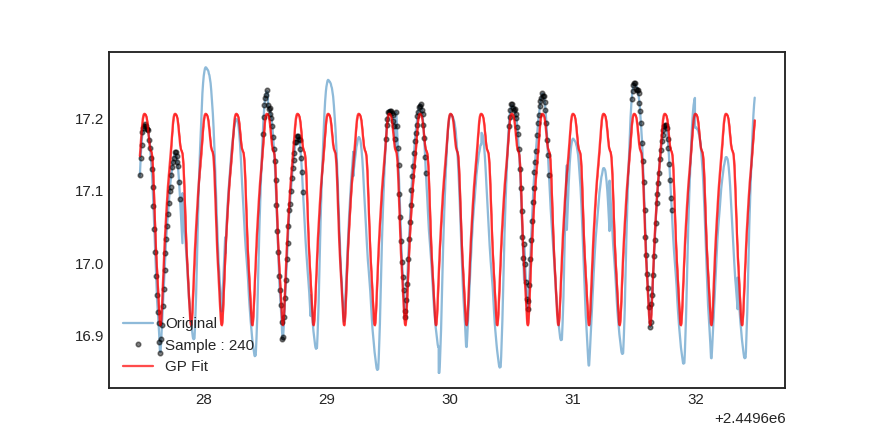

In [65]:
ndim, nwalkers = 4, 100
days, delay = 5,0

tsample, fsample, time, flux, flux_err, ax = sample(days, delay, plot=True)
data_pts = len(tsample)

In [66]:
###initialize walker parameters
params = [np.mean(fsample), -0.5, 1, -2]
p0, gp = walker_params(params=params, cov_scale=1, plot=True)


amp : 0.606530659713
      fun: 22863.73096702204
 hess_inv: array([[  1.00000000e+00,   2.16116224e-10,   3.32528005e-10,
         -1.66913185e-06],
       [  2.16116224e-10,   9.99999684e-01,  -1.16465625e-06,
          1.27434054e-03],
       [  3.32528005e-10,  -1.16465625e-06,   9.99997105e-01,
          7.09585019e-03],
       [ -1.66913185e-06,   1.27434054e-03,   7.09585019e-03,
          6.83757786e-05]])
      jac: array([  6.20590342e-02,  -4.24697917e+01,  -2.55839998e+02,
        -7.37309265e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 26
      nit: 1
     njev: 14
   status: 2
  success: False
        x: array([ 17.11525106,  -0.50007965,   0.99987391,  -1.39091   ])
[ 17.11525106  -0.50007965   0.99987391  -1.39091   ]


In [67]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood)

In [68]:
%%time
mcmc_sampling = sampler.run_mcmc(p0, 300)

/home/christina/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in log


CPU times: user 12min 38s, sys: 7min 45s, total: 20min 24s
Wall time: 5min 6s


In [ ]:
def save_chain(chain=sampler.chain, file_name='chain.pkl'):
    #write to file
    output = open(file_name, 'wb')
    pickle.dump(chain, output)
    output.close()
    
def read_chain(file_name='chain.pkl'):
    #read from file
    output = open('chain.pkl', 'rb')
    chain_data = pickle.load(output)
    output.close()
    return chain_data

<IPython.core.display.Javascript object>


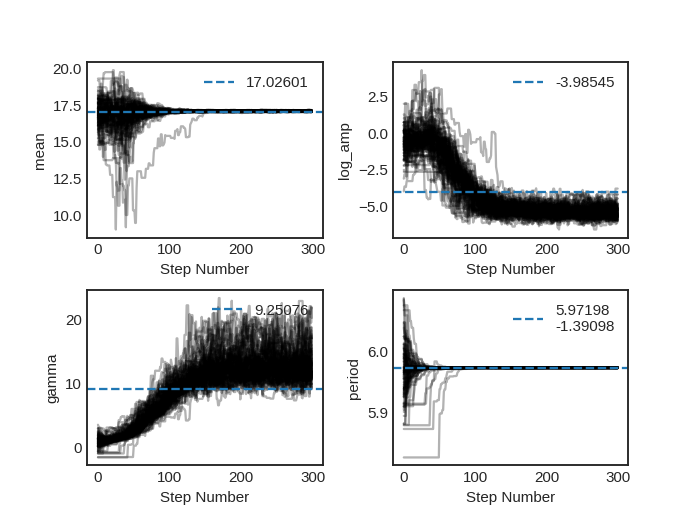

[ 17.68129723  -1.50968037  -0.2465047   -1.39684085]
Data points: 240
Mean acceptance fraction: 0.531


In [69]:
cgp.plot_steps(sampler, p0, data_pts)

<IPython.core.display.Javascript object>


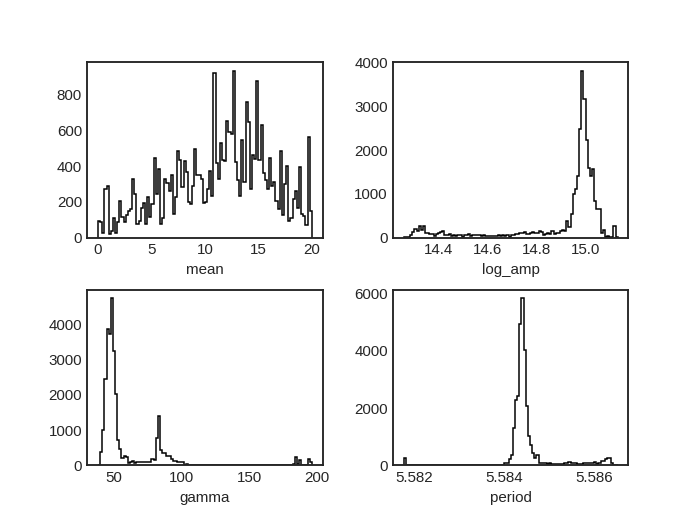

In [19]:
cgp.plot_hist(sampler)

In [ ]:
fig = corner.corner(sampler.flatchain)

## Playing around down here.

In [70]:
def plot_lightcurve(time, flux, flux_err=None, true_lightcurve=None, 
                    models=None, ax=None, colours=None):
    
    """
    Plot a light curve, potentially including the true underlying 
    model that produced the data (in the case of simulations), or model 
    light curves from MCMC. 
    
    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve
        
    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps
         
    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data. 
    true_lightcurve : iterable containing (true_time, true_flux)
        In the case of simulated data, this contains the times and flux values from which the 
        simulated data was created (could be higher-resolution than the "data"), useful for 
        comparison between models created e.g. from MCMC samples and the true underlying process
                
    models : iterable of shape (model_time, numpy.ndarray of shape (nsamples, len(model_time)))
        First element here contains the time stamps for the models (which may not be the same 
        as for the data), the second is an array of shape (nsamples, ndatapoints), where nsamples 
        is the number of model light curves, and ndatapoints == len(model_time)
        
    ax : matplotlib.Axes object
        An Axes object in which to plot the results. If not given, the code will create a 
        new figure.
                
    legend : bool, default True
        If True, include a legend in the plot
        
    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second 
        colour for the true underlying data, the third for the models.
    
    Returns
    -------
    
    ax : matplotlib.Axes object
        The object with the plot
    
    """
    
    if colours is None:
        colours = ["black", "#33B3FF", "#FFB733"]
        
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    if flux_err is None:
        ax.scatter(time, flux, s=4, c=colours[0], marker="o")
    else:
        ax.errorbar(time, flux, yerr=flux_err, fmt="o", markersize=4, c=colours[0])
     
    min_time = np.min(time)
    max_time = np.max(time)

    if true_lightcurve is not None:
        true_time = true_lightcurve[0]
        true_flux = true_lightcurve[1]
        
        ax.plot(true_time, true_flux, lw=2, alpha=0.5, color=colours[1])

        min_time = np.min([min_time, np.min(true_time)])
        max_time = np.max([max_time, np.max(true_time)])


    if models is not None:
        m_time = models[0]
        m_flux = models[1]
        
        for m in m_flux:
            ax.plot(m_time, m, color=colours[2], alpha=0.1)

        min_time = np.min([min_time, np.min(m_time)])
        max_time = np.max([max_time, np.max(m_time)])
    
    ax.set_xlim(min_time, max_time)
    ax.set_xlabel("Time")
    ax.set_ylabel("Flux");
        
    return ax

def plot_folded_lightcurve(time, flux, period, flux_err=None, models=None, true_lightcurve=None, 
                      ax=None, use_radians=False, legend=True, colours=None):
    """
    Plot a folded periodic light curve, potentially including the true underlying 
    model that produced the data (in the case of simulations), or model 
    light curves from MCMC. 
    
    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve
        
    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps
         
    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data. 
        
    period : float
        The period on which to fold **in hours**
        
    models : iterable of shape (model_time, numpy.ndarray of shape (nsamples, len(model_time)))
        First element here contains the time stamps for the models (which may not be the same 
        as for the data), the second is an array of shape (nsamples, ndatapoints), where nsamples 
        is the number of model light curves, and ndatapoints == len(model_time)
        
    true_lightcurve : iterable containing (true_time, true_flux)
        In the case of simulated data, this contains the times and flux values from which the 
        simulated data was created (could be higher-resolution than the "data"), useful for 
        comparison between models created e.g. from MCMC samples and the true underlying process
        
    ax : matplotlib.Axes object
        An Axes object in which to plot the results. If not given, the code will create a 
        new figure.
        
    use_radians : bool, default False
        If True, the phase will be plotted from (0, 2pi) instead of (0,1), which is the default.
        
    legend : bool, default True
        If True, include a legend in the plot
    
    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second 
        colour for the true underlying data, the third for the models.
    Returns
    -------
    
    ax : matplotlib.Axes object
        The object with the plot
    
    """
    
    if colours is None:
        colours = ["black", "#33B3FF", "#FFB733"]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))
    
    t0 = np.min(time)
    
    if models:
        t0 = np.min([t0, np.min(models[0])])
    
    if true_lightcurve:
        t0 = np.min([t0, np.min(true_lightcurve[0])])

    phase = (time-t0)/period - np.floor((time-t0)/period)
    
    if use_radians:
        phase *= 2.*np.pi
    
    if flux_err is None:
        ax.scatter(phase, flux, s=5, color=colours[0], label="data")
    else:
        ax.errorbar(phase, flux, yerr=flux_err, fmt="o", c=colours[0], markersize=2, label="data")
    
    if true_lightcurve:
        true_time = (true_lightcurve[0] - t0)
        true_flux = true_lightcurve[1]
        true_phase = true_time/period - np.floor(true_time/period)
        
        if use_radians:
            true_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(true_phase)

        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]

        # loop through indices where phase goes from 1 (or 2pi) to 0
        # plot each phase light curve separately
        istart = 0
        iend = idx[0]+1
        
        # first phase cycle also contains the label for the legend
        ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3, 
                c=colours[1], label="true light curve")

        for i, x in enumerate(idx[:-1]):
            ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3, c=colours[1])
            istart = x+1
            iend = idx[i+1]+1        
        
        # last plot
        istart = idx[-1]+1
        ax.plot(true_phase[istart:], true_flux[istart:], alpha=0.3, c=colours[1])
    
    if models:
        m_time = (models[0] - t0)
        m_flux = models[1]
        
        m_phase = (m_time/period) - np.floor(m_time/period)
        if use_radians:
            m_phase *= 2.*np.pi
        
        # compute the difference from one phase bin to the next
        tdiff = np.diff(m_phase)
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]

        
        # loop through the different samples
        for i,m in enumerate(m_flux):
            # loop through indices where phase goes from 1 (or 2pi) to 0
            # plot each phase light curve separately
            istart = 0
            iend = idx[0]+1
            
            if i == 0:
                # first phase cycle also contains the label for the legend
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1, 
                        c=colours[2], label="model")

            else:
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1, 
                        c=colours[2])

            for j, x in enumerate(idx[:-1]):
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1, c=colours[2])
                istart = x+1
                iend = idx[j+1]+1        

            # last plot
            istart = idx[-1]+1
            ax.plot(m_phase[istart:], m[istart:], alpha=0.1, c=colours[2])

    #if legend:
     #   ax.legend()
    ax.set_xlabel("Rotational Phase")
    ax.set_ylabel("Plot")
    ax.set_title(r"period $P = %.3f$"%period)
    if use_radians:
        ax.set_xlim(0, 2*np.pi)
    else:
        ax.set_xlim(0, 1)
    return ax


In [71]:
def plot_sampling_results(time, flux, flux_err, gp, sampler,
                          t_pred=None, true_lightcurve=None,
                          true_period=None, namestr="test", 
                          nmodels=10, npred=1000):
    
    
    # resample from weights
    new_samples = sampler.flatchain
    
    # make a corner plot
    corner.corner(new_samples, labels=gp.get_parameter_names())

    # save to file
    plt.savefig(namestr + "_corner.pdf", format="pdf")

    # plot some light curves with example models

    # first, get the total number of available samples
    nsamples = new_samples.shape[0]

    # get some random samples from the 

    idx = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nmodels)

    # if the array for the predictions isn't given, make one
    if t_pred is None:
        t_pred = np.linspace(time.iloc[0], time.iloc[-1], npred)

    # empty array for output
    m_all = np.zeros((nmodels, t_pred.shape[0]))

    # loop through the indices of samples, for each sample from the GP
    # conditional on the data points
    for i,j in enumerate(idx):
        p = new_samples[j]
        pnew = [p[0], p[1], p[2], p[3]]

        gp.set_parameter_vector(pnew)
        mean_model = gp.sample_conditional(fsample, t_pred)
        m_all[i] = mean_model

    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    plot_lightcurve(tsample, fsample, true_lightcurve=true_lightcurve, 
                        models=(t_pred, m_all), ax=ax)

    plt.tight_layout()
    plt.savefig(namestr + "_lc.pdf", format="pdf")

    # plot histogram of periods
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    ax.hist(np.exp(new_samples[:,-1])*24, bins=100, normed=True, 
                label="posterior PDF", color="black", alpha=0.5)

    if true_period is not None:
        ylim = ax.get_ylim()
        ax.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="true period : " + str(true_period))

    ax.set_xlabel("Period in hours")
    ax.set_ylabel("Probability")
    ax.legend()

    plt.tight_layout()
    plt.savefig(namestr + "_period_pdf.pdf", format="pdf")

    # plot folded light curve

    fig, ax = plt.subplots(1, 1, figsize=(6,4))


    if true_period:
        ax = plot_folded_lightcurve(tsample, fsample, true_period/24, flux_err=0.01, 
                          models=[t_pred, m_all[:2]], 
                          true_lightcurve=true_lightcurve, ax=ax, use_radians=False)
    else:
        ax = plot_folded_lightcurve(tsample, fsample, best_period, flux_err=ferr, 
                          models=[t_pred, m_all[:2]], 
                          true_lightcurve=true_lightcurve, ax=bx, use_radians=False)

    plt.tight_layout()
    plt.savefig(namestr + "_folded_lc.pdf", format="pdf")


In [72]:
#true_period = 3.603957 # 3200 Phaeton
true_period = 5.58410 # 1291 Phryge

In [74]:
plot_sampling_results(tsample, fsample, flux_err, gp, sampler, true_lightcurve = [time, flux])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NameError: global name 'best_period' is not defined